In [32]:
import TurbPy as tb
from TurbPy.imports import *

In [33]:
# deck = 'KH_Lv1di/'
# deck = 'KH/'
# deck = 'KH_subash/'
# deck = 'KH_400ppc/'
deck = 'KH_800ppc/'
# deck = 'KH_new/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)

en_out = tb.read_energies(dirs) /(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx = info['Lx/di']
ly = info['Ly/di']
nx = int(info['nx'])
ny = int(info['ny'])

In [34]:
from TurbPy.vpic_info import *
from TurbPy.load_vars import *
import numpy as np
import pandas as pd


def read_energies(dirs):
  fdata = np.genfromtxt(dirs + "rundata/energies", skip_header=3)
  en_dict = {}
  ene_electric = np.sum(fdata[:, 1:4], axis=1)
  ene_magnetic = np.sum(fdata[:, 4:7], axis=1)
  ene_ion = fdata[:, 7]
  ene_electron = fdata[:, 8]
  ene_tot = np.sum(fdata[:, 1:], axis=1)

  en_dict['EE'] = ene_electric
  en_dict['EM'] = ene_magnetic
  en_dict['Ei'] = ene_ion
  en_dict['Ee'] = ene_electron
  en_dict['Et'] = ene_tot
  return pd.DataFrame(en_dict)

def read_calc_energies(dirs):
  fdata = pd.read_csv(dirs + 'en_calc.csv')

  en_dict = {}
  en_dict['EE'] = fdata['EE']
  en_dict['EM'] = fdata['EM']

  en_dict['Ethi'] = fdata['Ethi']
  en_dict['Efi'] = fdata['Efi']
  en_dict['Ei'] = fdata['Efi'] + fdata['Ethi']

  en_dict['Ethe'] = fdata['Ethe']
  en_dict['Efe'] = fdata['Efe']
  en_dict['Ee']  = fdata['Efe'] + fdata['Ethe']
  
  en_dict['Et'] = fdata['Et']
  return pd.DataFrame(en_dict)


def en_calc(dirs, save = True):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_fe = np.zeros(len(times))
  E_the = np.zeros(len(times))
  E_fi = np.zeros(len(times))
  E_thi = np.zeros(len(times))
  E_m = np.zeros(len(times))
  E_e = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']
    ds = load_vars(dirs,times[t], 'ion')
    E_m[t] = (1/2) * np.sum(ds['cbx']**2 + ds['cby']**2 + ds['cbz']**2) * dx * dy *dz
    E_e[t] = (1/2) * np.sum(ds['ex']**2 + ds['ey']**2 + ds['ez']**2) * dx * dy * dz

    particle_mass = int(vpic_info['mi/me'])
    pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    
    # ux=ds['jx']/ds['rho']
    # uy=ds['jy']/ds['rho']
    # uz=ds['jz']/ds['rho']
    ux=ds['px']/np.abs(ds['rho'])/particle_mass
    uy=ds['py']/np.abs(ds['rho'])/particle_mass
    uz=ds['pz']/np.abs(ds['rho'])/particle_mass

    E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fi[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

    ds = load_vars(dirs,times[t], 'electron')
    particle_mass = 1
    pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    
    # ux=ds['jx']/ds['rho']
    # uy=ds['jy']/ds['rho']
    # uz=ds['jz']/ds['rho']
    ux=ds['px']/np.abs(ds['rho'])/particle_mass
    uy=ds['py']/np.abs(ds['rho'])/particle_mass
    uz=ds['pz']/np.abs(ds['rho'])/particle_mass

    E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fe[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

  en['EM'] = E_m
  en['EE'] = E_e
  en['Ethi'] = E_thi
  en['Efi'] = E_fi
  en['Ethe'] = E_the
  en['Efe'] = E_fe
  en['Et'] = E_m + E_e + E_thi + E_fi + E_the + E_fe
  if save == True:
    pd.DataFrame(en).to_csv(dirs + 'en_calc.csv', sep = ',')
  return pd.DataFrame(en)

def EM_calc(dirs):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_m = np.zeros(len(times))
  E_e = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']
    ds = load_vars(dirs,times[t])
    E_m[t] = (1/2) * np.sum(ds['cbx']**2 + ds['cby']**2 + ds['cbz']**2) * dx * dy *dz
    E_e[t] = (1/2) * np.sum(ds['ex']**2 + ds['ey']**2 + ds['ez']**2) * dx * dy * dz
  en['EM'] = E_m
  en['EE'] = E_e
  return pd.DataFrame(en)

def ion_calc(dirs):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  E_fi = np.zeros(len(times))
  E_thi = np.zeros(len(times))


  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']
    ds = load_vars(dirs,times[t], 'ion')

    particle_mass = int(vpic_info['mi/me'])
    pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    
    ux = ds['jx']/ds['rho']
    uy = ds['jy']/ds['rho']
    uz = ds['jz']/ds['rho']

    E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fi[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz
  
  en['Ethi'] = E_thi
  en['Efi'] = E_fi
  return pd.DataFrame(en)

def electron_calc(dirs):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_fe = np.zeros(len(times))
  E_the = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']

    ds = load_vars(dirs,times[t], 'electron')
    particle_mass = 1
    pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    
    ux=ds['jx']/ds['rho']
    uy=ds['jy']/ds['rho']
    uz=ds['jz']/ds['rho']

    E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fe[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

  en['Ethe'] = E_the
  en['Efe'] = E_fe
  return pd.DataFrame(en)

In [35]:
en = en_calc(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
# en = tb.read_calc_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

In [36]:
print(en)

          EM        EE      Ethi       Efi      Ethe       Efe        Et
0   0.125000  0.000065  0.018754  0.026215  0.018186  0.000272  0.188492
1   0.125017  0.000074  0.018772  0.026151  0.018198  0.000287  0.188499
2   0.125013  0.000079  0.018787  0.026119  0.018225  0.000285  0.188508
3   0.125014  0.000080  0.018811  0.026070  0.018254  0.000288  0.188517
4   0.125022  0.000080  0.018831  0.026022  0.018285  0.000287  0.188526
..       ...       ...       ...       ...       ...       ...       ...
76  0.125901  0.000067  0.021349  0.016161  0.025278  0.000338  0.189094
77  0.125929  0.000067  0.021371  0.016036  0.025359  0.000341  0.189103
78  0.125949  0.000067  0.021397  0.015919  0.025438  0.000343  0.189113
79  0.125956  0.000066  0.021423  0.015811  0.025528  0.000337  0.189122
80  0.125951  0.000066  0.021458  0.015710  0.025617  0.000329  0.189130

[81 rows x 7 columns]


In [37]:
dEM = en['EM'] - en['EM'][0]
dEE = en['EE'] - en['EE'][0]

dEi = (en['Efi']  + en['Ethi']) - (en['Efi'] + en['Ethi'])[0]
dEthi = en['Ethi'] - en['Ethi'][0]
dEfi = en['Efi'] - en['Efi'][0]

dEe = (en['Efe'] + en['Ethe']) - (en['Efe'] + en['Ethe'])[0]
dEthe = en['Ethe'] - en['Ethe'][0]
dEfe = en['Efe'] - en['Efe'][0]

dEt = en['Et'] - en['Et'][0]


In [38]:
dEM_out = (en_out['EM'] + en_out['EE']) - (en_out['EM'][0] + en_out['EE'][0])
dEE_out = en_out['EE'] - en_out['EE'][0]

dEi_out = en_out['Ei'] - en_out['Ei'][0]

dEe_out = en_out['Ee'] - en_out['Ee'][0]

dEt_out = en_out['Et'] - en_out['Et'][0]
print(en_out)

            EE        EM        Ei        Ee        Et
0     0.000065  0.125000  0.044968  0.018727  0.188760
1     0.000071  0.125001  0.044951  0.018737  0.188760
2     0.000070  0.125001  0.044936  0.018753  0.188760
3     0.000068  0.125002  0.044952  0.018739  0.188760
4     0.000072  0.125002  0.044961  0.018726  0.188761
...        ...       ...       ...       ...       ...
2892  0.000066  0.125951  0.037177  0.026470  0.189664
2893  0.000066  0.125951  0.037175  0.026472  0.189664
2894  0.000066  0.125951  0.037173  0.026475  0.189664
2895  0.000066  0.125951  0.037171  0.026477  0.189665
2896  0.000066  0.125951  0.037170  0.026479  0.189665

[2897 rows x 5 columns]


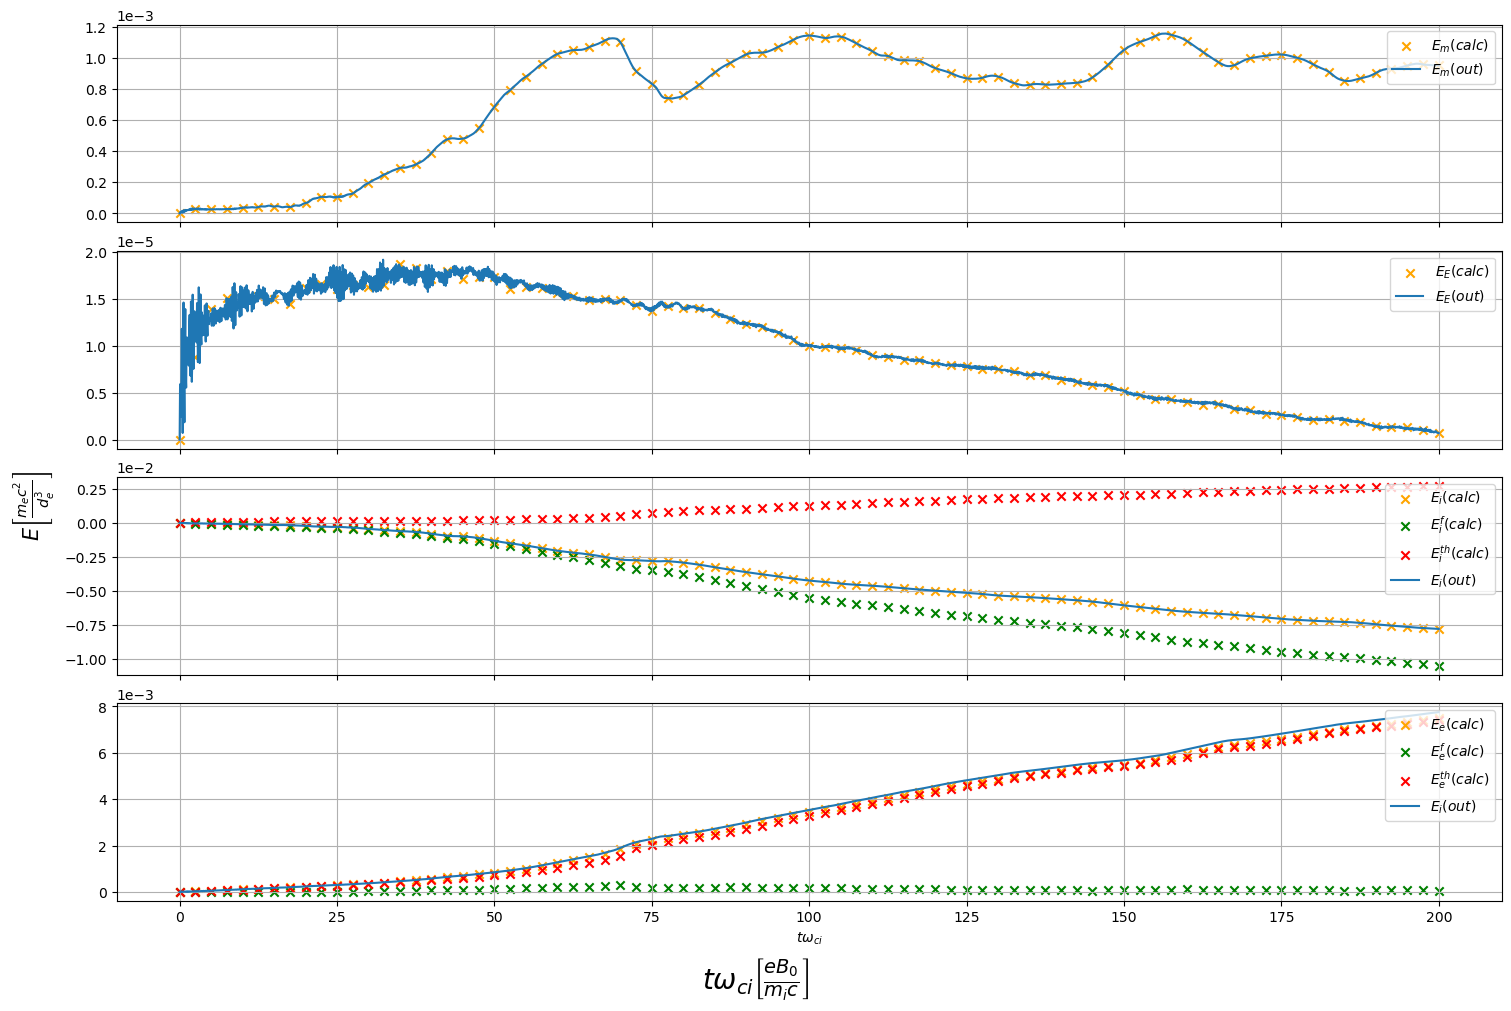

In [39]:
fig, axs = plt.subplots(4,1, figsize=(15, 10), sharex = True, layout='constrained')
axs[0].scatter(twci, dEM + dEE, color = 'orange', marker = 'x' , label = r'$E_m (calc)$')
axs[0].plot(twci_out, dEM_out , label = r'$E_m (out)$')

axs[1].scatter(twci, dEE, color = 'orange', marker = 'x', label = r'$E_E (calc)$')
axs[1].plot(twci_out, dEE_out, label = r'$E_E (out)$')

axs[2].scatter(twci, dEi, color = 'orange', marker = 'x' , label = r'$E_i (calc)$')
axs[2].scatter(twci, dEfi, color = 'green', marker = 'x' , label = r'$E^{f}_i (calc)$')
axs[2].scatter(twci, dEthi, color = 'red', marker = 'x' , label = r'$E^{th}_i (calc)$')
axs[2].plot(twci_out, dEi_out , label = r'$E_i (out)$')

axs[3].scatter(twci, dEe, color = 'orange', marker = 'x', label = r'$E_e (calc)$')
axs[3].scatter(twci, dEfe, color = 'green', marker = 'x' , label = r'$E^{f}_e (calc)$')
axs[3].scatter(twci, dEthe, color = 'red', marker = 'x' , label = r'$E^{th}_e (calc)$')
axs[3].plot(twci_out, dEe_out, label = r'$E_i (out)$')

axs[0].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[1].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[2].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[3].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

axs[3].set_xlabel(r'$t \omega_{ci}$')

axs[0].legend(loc = 'upper right')
axs[1].legend(loc = 'upper right')
axs[2].legend(loc = 'upper right')
axs[3].legend(loc = 'upper right')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

plt.savefig(figs + 'dE_split.jpg', dpi = 400)

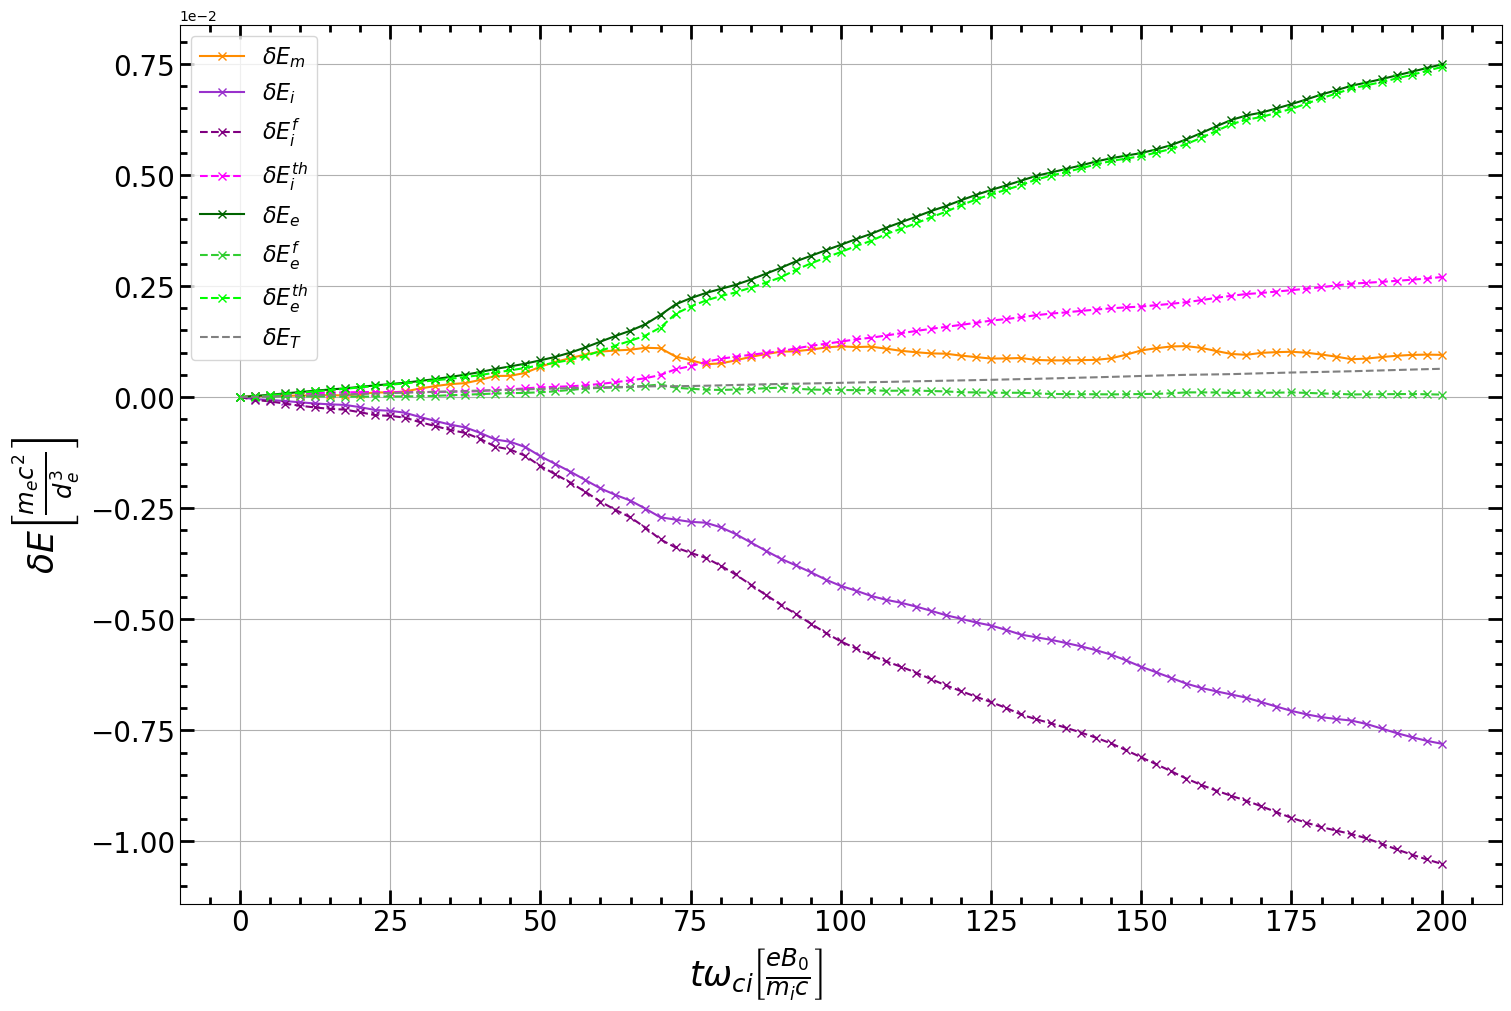

In [42]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
axs.plot(twci, dEM + dEE, color = 'darkorange', marker = 'x' , label = r'$\delta E_m$')
# axs.plot(twci_out, dEM_out , color = 'aqua', label = r'$E_m (out)$')

# axs.scatter(twci, dEE, color = 'orange', marker = 'x', label = r'$E_E (calc)$')
# axs.plot(twci_out, dEE_out, label = r'$E_E (out)$')

axs.plot(twci, dEi,     color = 'darkorchid', marker = 'x' , label = r'$\delta E_i$')
axs.plot(twci, dEfi, color = 'purple',    marker = 'x' , linestyle = '--', label = r'$\delta E^{f}_i$')
axs.plot(twci, dEthi,color = 'magenta',   marker = 'x' , linestyle = '--', label = r'$\delta E^{th}_i$')
# axs.plot(twci_out, dEi_out , label = r'$E_i (out)$')

axs.plot(twci, dEe,   color = 'darkgreen', marker = 'x', label = r'$\delta E_e$')
axs.plot(twci, dEfe,  color = 'limegreen'   , marker = 'x' ,linestyle = '--', label = r'$\delta E^{f}_e$')
axs.plot(twci, dEthe, color = 'lime', marker = 'x' ,linestyle = '--', label = r'$\delta E^{th}_e$')
axs.plot(twci, dEt, color = 'gray', linestyle = '--', label = r'$\delta E_T$')
# axs.plot(twci_out, dEe_out, label = r'$E_i (out)$')

axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

axs.legend(loc = 'upper left', fontsize = 16)

axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
axs.tick_params(which='major', length=10, top = True, right =True)
axs.tick_params(which='minor', length=5 , top = True, right =True)

axs.grid()
# axs.set_ylim(-4.5 * 10**(-3), 3.2 * 10**(-3))
fig.supylabel(r'$\delta E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 25)

plt.savefig(figs + 'dE.jpg', dpi = 400)